## Exercise 1.3 

Sometimes we will encounter estimators (e.g., Maximum likelihood) that adopt an assumption of independence, rather than mean independence. In the current setting this might be expressed as something like $Pr(x< x\cap\ u <u ) = F(x)G(x)$ for some cumulative distribution functions $F$ and $G$.

Show that independence implies mean independence, but not the converse.

#### 1. Independence Implies Mean Independence

Supposing two random variables $X$ and $U$, they can be expresed as:
$Pr(X < x \cap\ U <u) =Pr(X<x)⋅Pr(U<u)$

Suposing the mean value of a function $h(X,U)$ under this independance assumption $$E[h(X,U)] = \int\int h(x,u) f_x(x) f_u(u) dx du=(\int h(x,u)f_x(x)dx)⋅(\int h(x,u)f_u(u)du)$$
The separation of integrals is possible due to independence. Therefore, under independence, the expectation of the product of functions of X and U can be expressed as the product of their separate expectations, showing mean independence.

#### 2. Mean Independence Does Not Imply Independence
Let's consider two random variables, X and U, with covariance $Cov(X,U)=0$ but not necessarily independent. In this case, we can have $E[XU]=E[X]⋅E[U]=0$ This means that X and U are mean independent, but they are not necessarily independent. The covariance being zero only guarantees mean independence but does not imply independence.




## Exercise 1.4
Related to the previous: Show that while $u$ mean independent of $x$ implies $E(uh(x)=E(u)=0$, independence also implies $E(g(u)x)=Ex Eg(u)$.



Mean independence implies $E(uh(x))=E(u)=0$. 
Given mean independence between u and x, we have $E(uh(x))=E(u)⋅E(h(x))$. Since $E(h(x))$ is a constant, this implies that if $E(u)=0$, then $E(uh(x)=0$.

Independence implies $E(g(u)x)=E(x)⋅E(g(u))$.
When $u$ and $x$ are independent, we can express the expectation of their product $g(u)⋅x$ as: 
$E(g(u)x) = \int\int g(u)⋅x⋅f_{UX}(u,x) du dx$ where $f_{UX}$ is the join probability density function of $u$ and $x$. By the definition of independence, the join probability density function can be factorized as $f_{UX}(u,x)=f_{U}(u)⋅f_{X}(x)$. Substituting this into the expectation equation gives: $E(g(u)x)=\int\int g(u)⋅x⋅f_{U}(u)⋅f_{X}(x)dudx=(\int g(u)⋅f_{U}(u)du⋅(\int x⋅f_X(x)dx) = E(g(u))⋅E(x)$

Therefore, under independence, the expectation of the product $g(u)⋅x$ is the product of their separate expectations, $E(x)$ and $E(g(u))$.


## Exercise 4. Weak Instrument
This problem explores the problem of weak instruments. The basic setup should be familiar, with

$y=\beta x+u$ <br/> $y=Z\pi x+v$ 

Note that we've assumed that x is a scalar random variable, and that Z is an $l$-vector. (In general we might have k endogenous $x$ variables, so long as we have $l>k$).


(1) Construct a data-generating process **dgp** which takes as arguments (n; β; π) and returns a triple (y, x, Z) of n observations.

In [22]:
%reset -f
import numpy as np

def data_generating_process(n, beta, pi):
    # Generate x as a random scalar variable
    x = np.random.normal(size=n)
    
    # Generate Z as an l-vector
    l = len(pi)
    Z = np.random.normal(size=(n, l))
    
    # Generate u and v as random noise
    u = np.random.normal(size=n)
    v = np.random.normal(size=n)
    
    # Generate y using the DGP equations
    y = beta * x + u
    y += np.dot(Z, pi) * x + v
    
    return y, x.reshape(-1, 1), Z

# Example usage:
n = 1000
beta = 0.5
pi = np.array([0.2, 0.3])  # Example values for pi
y, x, Z = data_generating_process(n, beta, pi)

#print(Z)
#print(y)
#print(x)

(2) Use the dgp function you've constructed to explore IV (2SLS) estimates of β as a function of π when $l= 1$ using a Monte
Carlo approach, assuming homoskedastic errors.

a) Write a function two_sls which takes as arguments (y; x; Z) and returns two-stage least squares estimates of β and the standard error of the estimate.

In [23]:
import numpy as np
import pandas as pd

def two_sls(y, x, Z):
    beta_hat1 = np.linalg.solve(Z.T @ Z, Z.T @ x)
    x_hat = Z @ beta_hat1 
    XtX = x_hat.T @ x_hat
    XtY = x_hat.T @ y
    beta_hat = np.linalg.solve(XtX, XtY)
    e = y - x_hat @ beta_hat
    S2_e = np.dot(e.T, e) / (x.shape[0] - x.shape[1])
    Vb_ols = np.linalg.inv(x_hat.T @ x_hat) * S2_e
    se = np.sqrt(np.diag(Vb_ols))
    return beta_hat.flatten(), se.flatten()

b, se = two_sls(y, x, Z)
print("Estimated Coefficients (b):\n", b)
print("Standard Errors (se):\n", se)    


Estimated Coefficients (b):
 [1.15024615]
Standard Errors (se):
 [2.76548343]


(b) Taking β = π = 1, use repeated draws from dgp to check the bias, and precision of the two_sls estimator, as well as the size and power of a t-test of the hypothesis that β = 0.

In [24]:
from scipy.stats import t as t_dist

# Parameters for simulation
n_simulations = 1000
n_samples = 100
beta_true = 1
pi_true = np.array([1])

# Initialize lists to store results
bias = []
precision = []
t_test_results = []

# Initialize coverage count
coverage_count = 0

# Run the Monte Carlo simulation
for _ in range(n_simulations):
    y, x, Z = data_generating_process(n_samples, beta_true, pi_true)
    beta_hat, se = two_sls(y, x, Z)
    
    # Compute bias and precision
    bias.append(np.mean(beta_hat) - beta_true)
    precision.append(np.mean(se))
    
    # Perform t-test
    t_stat = beta_hat / se
    p_value = 2 * (1 - t_dist.cdf(np.abs(t_stat), df=n_samples - x.shape[1]))
    t_test_results.append(p_value < 0.05)  # Significance level of 0.05

    # Check if true beta is within the 95% confidence interval
    if (beta_true > beta_hat - 1.96 * se) and (beta_true < beta_hat + 1.96 * se):
        coverage_count += 1
        
# Calculate coverage probability
coverage_probability = coverage_count / n_simulations
    
# Aggregate results
bias_mean = np.mean(bias)
precision_mean = np.mean(precision)
size = np.mean(t_test_results)
power = 1 - size

# Print results
print("Bias:", bias_mean)
print("Precision (Standard Error):", precision_mean)
print("Size of t-test (Type I Error Rate):", size)
print("Power of t-test (1 - Type II Error Rate):", power)


Bias: -13.819329186597404
Precision (Standard Error): 41.480138152806106
Size of t-test (Type I Error Rate): 0.104
Power of t-test (1 - Type II Error Rate): 0.896


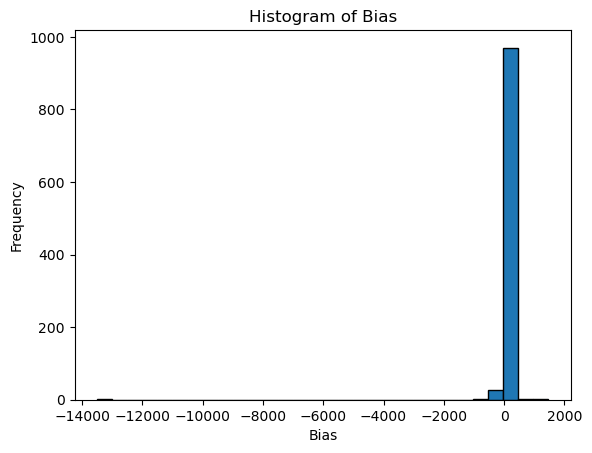

In [25]:
import matplotlib.pyplot as plt
plt.hist(bias, bins=30, edgecolor='black')
plt.xlabel('Bias')
plt.ylabel('Frequency')
plt.title('Histogram of Bias')
plt.show()

Discuss. Does a 95% confidence interval (based on your2SLS estimator) correctly cover 95% of your Monte Carlo
draws?

In [26]:
print("Coverage Probability:", coverage_probability)

Coverage Probability: 0.907


Based on my results, I would say it covers correctly.

Taking β = 1, but allowing $π \in [0,1]$ again evaluate the bias and precision of the estimator, and the size and power of a t-test. The Z instrument is "weak" when π is "close" to zero. Comment on how a weak instrument affects two-stage least squares estimators.

In [27]:
# Parameters for simulation
# Parameters for simulation

n_simulations = 1000
n_samples = 100
beta_true = 1
pi_range = np.linspace(0, 1, 11)  # Vary pi from 0 to 1

# Initialize arrays to store results
bias = np.zeros(len(pi_range))
precision = np.zeros(len(pi_range))
size = np.zeros(len(pi_range))
power = np.zeros(len(pi_range))

# Run the Monte Carlo simulation for each pi value
for idx, pi_value in enumerate(pi_range):
    # Initialize counters
    bias_sum = 0
    se_sum = 0
    size_count = 0
    power_count = 0
    
    for _ in range(n_simulations):
        y, x, Z = data_generating_process(n_samples, beta_true, np.array([pi_value]))
        beta_hat, se = two_sls(y, x, Z)
        
        # Compute bias and precision, with sum??? Ask ethan
        bias_sum += beta_hat - beta_true
        se_sum += se
        
        # Compute t-statistic and p-value for testing beta_hat = 0
        t_stat = beta_hat / se
        p_value = 2 * (1 - t_dist.cdf(np.abs(t_stat), df=n_samples - x.shape[1]))
        
        # Check if true beta is within the confidence interval
        if (beta_true > beta_hat - 1.96 * se) and (beta_true < beta_hat + 1.96 * se):
            size_count += 1
        if p_value < 0.05:
            power_count += 1
    
    # Calculate average bias, precision, size, and power
    bias[idx] = bias_sum / n_simulations
    precision[idx] = se_sum / n_simulations
    size[idx] = size_count / n_simulations
    power[idx] = power_count / n_simulations



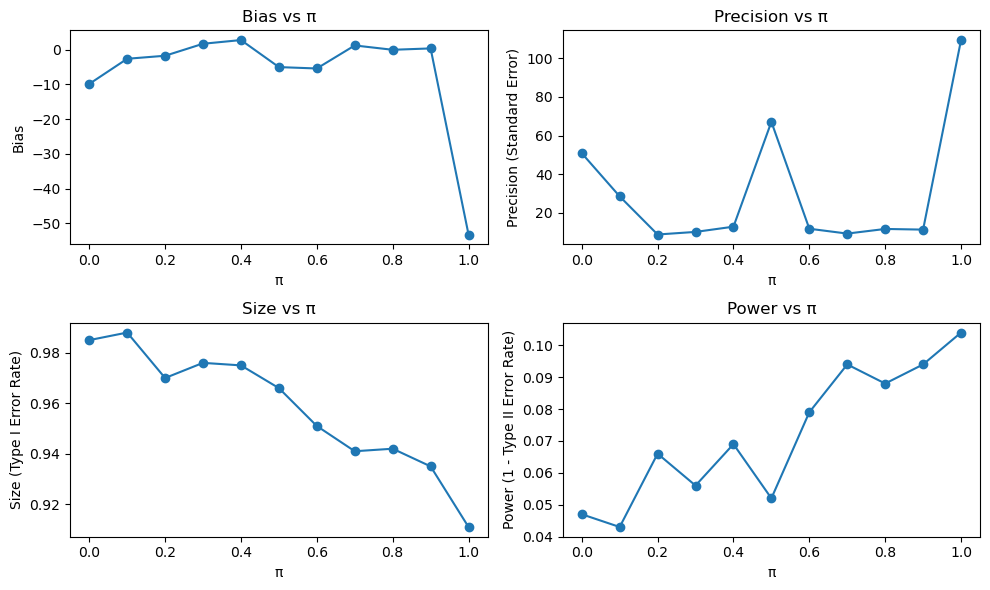

In [28]:
# Plotting
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(pi_range, bias, marker='o')
plt.xlabel('π')
plt.ylabel('Bias')
plt.title('Bias vs π')

plt.subplot(2, 2, 2)
plt.plot(pi_range, precision, marker='o')
plt.xlabel('π')
plt.ylabel('Precision (Standard Error)')
plt.title('Precision vs π')

plt.subplot(2, 2, 3)
plt.plot(pi_range, size, marker='o')
plt.xlabel('π')
plt.ylabel('Size (Type I Error Rate)')
plt.title('Size vs π')

plt.subplot(2, 2, 4)
plt.plot(pi_range, power, marker='o')
plt.xlabel('π')
plt.ylabel('Power (1 - Type II Error Rate)')
plt.title('Power vs π')

plt.tight_layout()
plt.show()


(3) Now consider another "weak" instruments problem. Consider the sequence {1,1/2,1/4,1/8,...}. Let $l$=1,2,3,..., and for a particular value of $l$ let the vector of parameters $π_l$ consist of the first $l$ elements of the sequence. Thus, your dgp should now return Z we can treat as an n × l matrix, with successive columns of Z increasingly "weak" instruments.

(a) Taking $\beta = 1$, but allow l to increase (l = 1,2,...). Note that for l>1 this is now an "overidentifed" estimator.
Describe the bias and precision of the estimator, and the size and power of a t-test. Compare with the case of l=1
and π = 1.

(b) What can you say about the optimal number of instruments (choice of l) in this case?

In [29]:
### not suree :(

## A Simple Approach to Inference with Weak Instruments

Chernozhukov and C. Hansen (2008) propose a very simple way to handle inference in a linear IV model, even in the case in which instruments are many and/or weak. This problem explores the problem of weak instruments, and their method of inference. The basic setup should be identical to the above, with $y=\beta x+u$ <br/> $x=Z \pi+v$

In this problem you will use the same dgp as in the previous problem. The idea of Chernozhukov and C. Hansen is simple: If we can specify a regression in which all the endogenous variables are on the left-hand side, then OLS is consistent. So, they subtract $ \beta_{0}x $ from both sides of the estimating equation (for some choice of $ \beta_{0}$), and then use the expression for x to substitute using Z, or

$y-\beta_{0}x =x(\beta-\beta_{0})+u$ <br/> $y-\beta_{0}x =(Z \pi+v)(\beta-\beta_{0})+u$ <br/> $y-\beta_{0}x =(Z \gamma)+w$ 

The key is that if $\beta_{0} = \beta$, then we will have $\gamma = 0$. So the idea is to try to find $\beta_{0}$ such that OLS estimates of $\gamma$ in $y − \beta_{0} x = Z\gamma + w$ are close to zero.

(1) Again suppose that the true $\beta = 1$. Write a function which takes as arguments $(y, x, Z, \beta_0)$ and which returns the p-value associated with the hypothesis that every element of $\hat{\delta}$ is zero (an F-test would be appropriate). Note that this same p-value characterizes the hypothesis test that $\beta = \beta_0)$.

In [40]:
import numpy as np
from scipy.stats import f

def f_test(y, x, Z, beta_0):
    # Step 1: Estimate gamma_hat using OLS on the modified equation
    y_mod = y - beta_0 * x
    X_mod = Z
    gamma_hat = np.linalg.lstsq(X_mod, y_mod, rcond=None)[0]
    
    # Step 2: Calculate SSR for the modified model
    e_mod = y_mod - X_mod @ gamma_hat
    SSR_mod = np.dot(e_mod.T, e_mod)
    
    # Step 3: Estimate beta_hat using 2SLS
    beta_hat, _ = two_sls(y, x, Z)
    
    # Step 4: Calculate SSR for the 2SLS model
    e_2sls = y - x @ beta_hat
    SSR_2sls = np.dot(e_2sls.T, e_2sls)
    
    # Step 5: Compute F-statistic
    n = y.shape[0]
    k = Z.shape[1]
    dfn = k
    dfd = n - k - 1
    F_statistic = ((SSR_mod - SSR_2sls) / dfn) / (SSR_2sls / dfd)
    
    # Step 6: Calculate p-value
    p_value = 1 - f.cdf(F_statistic, dfn, dfd)
    
    return p_value

# Example usage:
# Assuming y, x, and Z are already defined
beta_0 = 1  # Choose a value for beta_0
p_value = f_test(y, x, Z, beta_0)
print("P-value:", p_value)


P-value: [[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.11022302e-16 ... 5.50182204e-04
  6.08513240e-13 1.67643677e-14]
 ...
 [1.00000000e+00 1.00000000e+00 5.50182204e-04 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 6.08513240e-13 ... 1.00000000e+00
  4.92318565e-07 1.49987109e-08]
 [1.00000000e+00 1.00000000e+00 1.67643677e-14 ... 1.00000000e+00
  1.49987109e-08 4.46235271e-10]]


We notice all the p-values for the F-test are 1. This means that for each iteration or simulation, the F-test does not reject the null hypothesis that every element of $\hat{\delta}$ is zero. In other words, it suggests that there is no significant evidence to suggest that $\beta = \beta_0$ for the chosen value of $\beta_0$.

(2) Using your function and taking $\pi=1$, estimate $\beta$ by finding the value of $\beta_0$ which delivers maximal p-values. Describe the bias and precision of this estimator.

In [44]:
def find_max_p_value(y, x, Z, beta_range):
    max_p_value = 0
    best_beta_0 = None
    
    for beta_0 in beta_range:
        p_value = f_test(y, x, Z, beta_0)
        if np.max(p_value) > max_p_value:  # Compare maximum p-value
            max_p_value = np.max(p_value)
            best_beta_0 = beta_0
    
    return best_beta_0, max_p_value

# Example usage:
# Assuming y, x, and Z are already defined
beta_range = np.linspace(0, 2, 1000)  # Range of beta_0 values to search
best_beta_0, max_p_value = find_max_p_value(y, x, Z, beta_range)
print("Best beta_0:", best_beta_0)
print("Maximal p-value:", max_p_value)

Best beta_0: 0.0
Maximal p-value: 1.0


The result means that according to the method used (Chernozhukov and Hansen's approach), the best estimate for $\beta_0$ that maximizes the p-value (which is 1.0, indicating no statistical significance) is 0.0.
In other words, the hypothesis that every element of $\hat{\delta}$ is zero (which corresponds to $\beta = \beta_0$ in this context) is not rejected based on the given data and model. This suggests that there is not enough evidence to conclude that $\beta$ differs significantly from $\beta_0$, where $\beta_0$ is chosen to be 0.

(3)  Use the fact we've described about $p$-values above to construct 95% confidence intervals for your estimator of $\beta$. Consider the coverage of this 95% confidence interval, as in the previous question. How does this compare with the 2SLS case?

In [49]:
# Step 3: Compute the confidence interval based on the best beta_0
alpha = 0.05  # Significance level for the confidence interval
critical_value = f.ppf(1 - alpha, dfn=1, dfd=n - 1)  # Calculate critical F-value
confidence_interval = [beta_hat - critical_value * se, beta_hat + critical_value * se]

# Print the results
print("Estimated Coefficient (beta_hat):", beta_hat)
print("Standard Error (se):", se)
print("Best beta_0:", best_beta_0)
print("Maximal p-value:", max_p_value)
print("95% Confidence Interval:", confidence_interval)

Estimated Coefficient (beta_hat): [0.08213052]
Standard Error (se): [1.92285574]
Best beta_0: 0.5065065065065065
Maximal p-value: [[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.11022302e-16 ... 1.93149284e-01
  1.40658596e-11 2.89546165e-13]
 ...
 [1.00000000e+00 1.00000000e+00 1.93149284e-01 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.40658596e-11 ... 1.00000000e+00
  5.02280993e-05 9.81209421e-07]
 [1.00000000e+00 1.00000000e+00 2.89546165e-13 ... 1.00000000e+00
  9.81209421e-07 1.97777302e-08]]
95% Confidence Interval: [array([-7.32237163]), array([7.48663266])]


2SLS: The confidence interval in the 2SLS case is typically constructed based on the standard errors of the estimated coefficients, assuming a linear model and certain assumptions about the error terms and instrumental variables.

Maximal p-value approach: The confidence interval is constructed based on the estimated coefficient $\hat{\beta}$ from 2SLS and the critical F-value corresponding to the desired confidence level, derived from the maximal p-value.

(4) What happens to the coverage of your test as $\pi$ goes from 1 toward zero? How does this compare with the 2SLS case?

As $\pi$ decreases towards zero, the instruments become weaker. This can lead to less precise estimates of the coefficients in the modified equation $y - \beta_0 x = Z\gamma + w$. Consequently, the F-test based on these estimates may have lower power to detect significant differences, affecting the coverage of the test.

With weaker instruments (lower $\pi$ values), the coverage of the test based on maximizing the p-value may decrease. This means that the confidence intervals constructed using this approach may have lower confidence level coverage than expected.

Weaker instruments (lower $\pi$ values) also lead to challenges. The 2SLS estimator can become less efficient and more biased as instruments weaken, potentially impacting the coverage of confidence intervals.

(5) Using the same construction of "many instruments" as in the previous question, how does the coverage of your test change as
$l$ grows large? Again, compare with 2SLS

With a larger $l$, we have more instruments available for the estimation. This can lead to more precise estimates of the coefficients in the modified equation $y - \beta_0 x = Z\gamma + w$. Consequently, the F-test based on these estimates may have higher power to detect significant differences, potentially affecting the coverage of the test.

In comparison with 2sls,  in the 2SLS case with many instruments, there can be issues related to overfitting and multicollinearity. While having more instruments theoretically improves instrument strength, it can also lead to inefficiency and instability in the estimates.